In [62]:
from sealeveltools.sl_class import *
import warnings
warnings.filterwarnings("ignore")
def load_testfiles():
    dire='/home/oelsmann/Julius/Scripts/sealeveltools/sealeveltools/data/'
    sat=xr.open_dataset(dire+'sat_data.nc')
    tg=xr.open_dataset(dire+'tg_data.nc')
    gnss=xr.open_dataset(dire+'gps_data.nc')    
    gia=xr.open_dataset(dire+'GIA_data.nc')
    ci=pd.read_csv(dire+'climate_indices.csv',index_col=[0])
    ci.index=pd.to_datetime(ci.index.values)
    return sat,tg,gnss,gia,ci

## Basic Example 1

Comparison of two independent datasets

common tasks:

* compute trends
* resample/interpolate (in space)
* add/subtract 2D data
* Correlate 3D data


example datasets:

* tide gauges (3d), GNSS (2d), model data (2d)
* sea level data (3d)


In [2]:
# import sealeveltools
from sealeveltools.sl_class import *
sat,tg,gnss,gia,ci = load_testfiles()

In [87]:
sl(sat).mean(dim='time')

<xarray.Dataset>
Dimensions:             (x: 12844)
Coordinates:
    lon                 (x) float64 7.029 5.129 4.985 ... -0.05653 0.05653
    lat                 (x) float64 60.97 60.93 60.94 ... 50.04 50.04 50.04
Dimensions without coordinates: x
Data variables:
    ssh                 (x) float64 -0.3131 -0.014 ... -0.01624 -0.01756
    ssh_std             (x) float64 0.0006951 8.694e-06 ... 6.479e-06 6.757e-06
    sig0_fitting_error  (x) float64 0.02823 0.08086 0.08379 ... 0.464 0.4737
    num_used_obs        (x) float64 466.8 4.724e+03 ... 4.706e+03 4.711e+03
    num_obs             (x) float64 1.033e+03 6.791e+03 ... 5.668e+03 5.647e+03
    mean_time_obs       (x) float64 6.415 4.45 4.291 4.197 ... 3.208 3.187 3.339

### 1. Compute trends

In [53]:
sl(tg).trend()

auto-select first variable  sla


<xarray.Dataset>
Dimensions:       (x: 52)
Coordinates:
    lat           (x) float64 ...
    index         (x) int64 ...
    lon           (x) float64 ...
    name          (x) object ...
Dimensions without coordinates: x
Data variables:
    trend         (x) float64 0.0006193 0.002263 ... 0.0005499 -0.0008737
    trend_un      (x) float64 0.002297 0.000819 0.0005381 ... 0.001341 0.001031
    trend_un_AR1  (x) float64 0.003696 0.001717 0.001354 ... 0.00218 0.002007
    AC            (x) float64 0.1078 0.07684 0.06201 ... 0.08198 0.07877 0.07941
    AC_unc        (x) float64 0.02253 0.008317 0.005531 ... 0.01369 0.01047
    offset        (x) float64 7.084 6.946 7.009 6.966 ... 7.004 7.072 6.988
    acos          (x) float64 0.09158 0.06387 0.04413 ... 0.0335 0.03821 0.04068
    asin          (x) float64 -0.05687 -0.04271 -0.04355 ... -0.06888 -0.0682
    phase         (x) float64 148.2 146.2 135.4 129.0 ... 114.1 119.0 120.8

different trend fitting options:

* least-squares (trend, seasonal components, ...)
* MLE (maximum likelihood estimation, Improved unceratinty estimation, noise models ... )
* kendall's tau (non-parametric trend estimation)

In [95]:
# trend computation
tg

<xarray.Dataset>
Dimensions:  (time: 332, x: 52)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-31 1992-02-29 ... 2019-08-31
    lat      (x) float64 ...
    index    (x) int64 ...
    lon      (x) float64 ...
    name     (x) object ...
Dimensions without coordinates: x
Data variables:
    sla      (time, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

plot  ['trend', 'trend_un', 'AC']
shape:  2 x 2


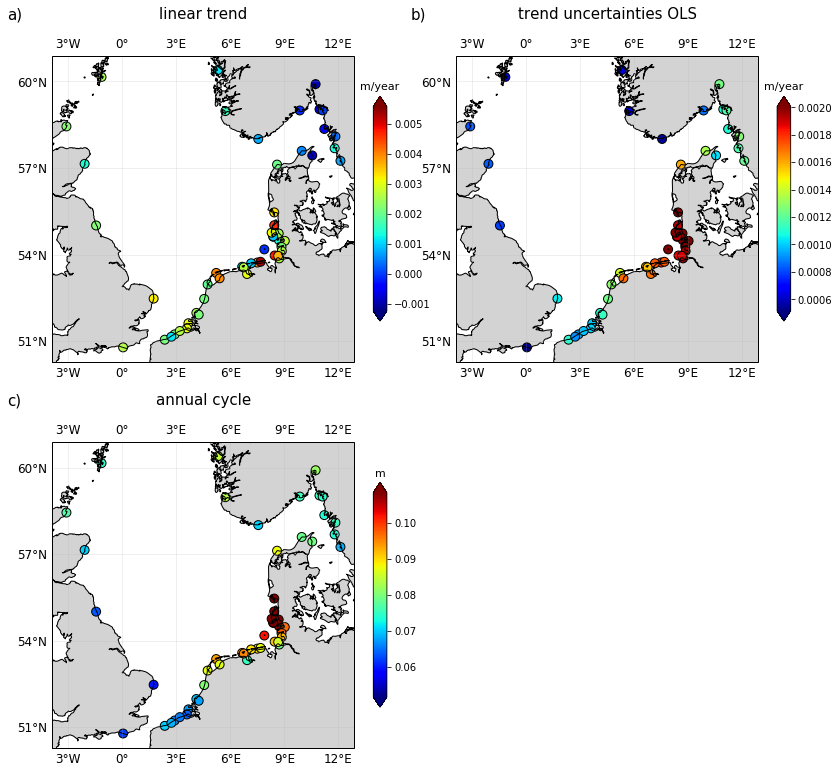

In [6]:
tg_trend.plot(var=['trend','trend_un','AC'],msize=80.,edgecolors=['k'],cmap='jet')

In [57]:
tg_trend

<xarray.Dataset>
Dimensions:       (x: 52)
Coordinates:
    lat           (x) float64 54.62 58.44 50.78 51.62 ... 59.0 59.91 57.6 57.44
    index         (x) int64 10 37 190 194 344 376 ... 363 364 365 528 602 604
    lon           (x) float64 8.383 -3.086 0.05703 3.682 ... 10.73 9.964 10.55
    name          (x) object 'AMRUM (WITTDUEN)' 'WICK' ... 'FREDERIKSHAVN'
Dimensions without coordinates: x
Data variables:
    trend         (x) float64 0.001052 0.002263 ... 0.0005499 -0.0008737
    trend_un      (x) float64 0.002258 0.000819 0.0005381 ... 0.001341 0.001031
    trend_un_AR1  (x) float64 0.003658 0.001717 0.001354 ... 0.00218 0.002007
    AC            (x) float64 0.1061 0.07684 0.06201 ... 0.08198 0.07877 0.07941
    AC_unc        (x) float64 0.02207 0.008317 0.005531 ... 0.01369 0.01047
    offset        (x) float64 7.076 6.946 7.009 6.966 ... 7.004 7.072 6.988
    acos          (x) float64 0.0885 0.06387 0.04413 ... 0.0335 0.03821 0.04068
    asin          (x) float64 -0.05845

### 2. Interpolation/smoothing/combination in space

plot  ['trend']
shape:  1 x 1


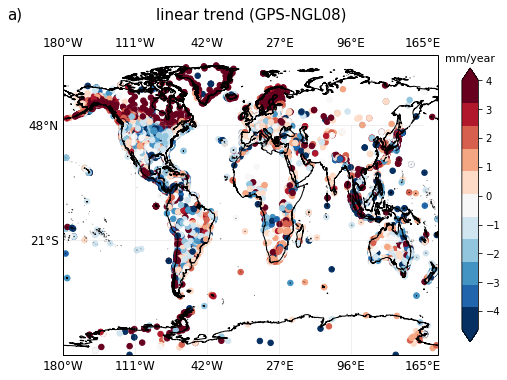

In [60]:
# subtract gps or gnss trends
sl(gnss).plot(msize=30.,f_x=1.2,f_y=1.2,land=False)

plot  ['trend']
shape:  1 x 1


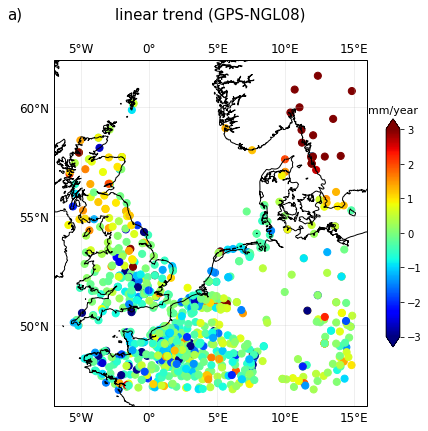

In [80]:
sl(gnss).box([-6,15,47,62]).plot(var='trend',msize=50.,cmap='jet',ranges=[[-3.,3.]],land=False)

no time
no time
plot  ['trend']
shape:  1 x 1


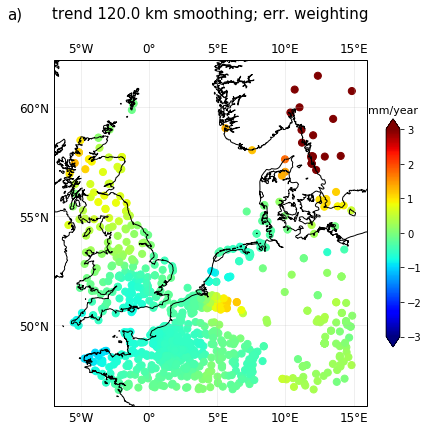

In [16]:
sl(gnss).box([-6,15,47,62]).remap(s_method='sfltr',limit=120.,stdon=True).plot(var='trend',msize=50.,cmap='jet',ranges=[[-3.,3.]],land=False)

Combining data in space | TG vs. GNSS

plot  ['trend', 'trend']
shape:  1 x 1


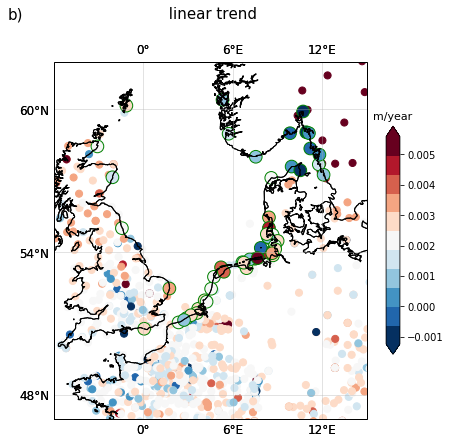

In [63]:
sl([gnss,tg_trend.data]).plot(var=['trend','trend'],extend=[-6,15,47,62],
           land=False,msize=[50.,160.],edgecolors=[None,'g'])

Combining data in space | TG vs. GIA 

plot  ['trend', 'trend']
shape:  1 x 1


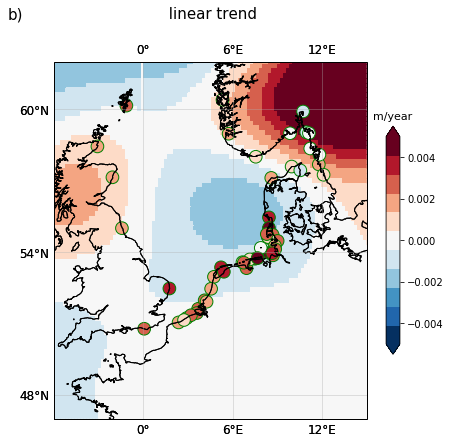

In [30]:
sl([(gia/1000.),tg_trend.data]).plot(var=['trend','trend'],extend=[-6,15,47,62],
           land=False,msize=[50.,160.],edgecolors=[None,'g'],ranges=[[-0.005,0.005]])

### 3. Adding data

swap
nearest
trend
100.0
plot  ['no_var']
shape:  1 x 1


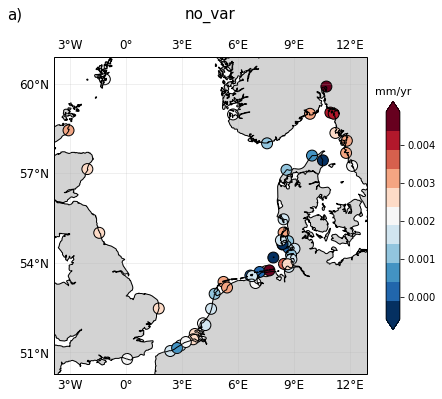

In [36]:
tg_abs_trend=tg_trend.__add__(gia['trend']/1000.,s_method='nearest',limit=100.)
tg_abs_trend.plot(msize=120,edgecolors=['k'])

-> absolute sea level trends

In [32]:
sat_trend=sl(sat).trend()

auto-select first variable  ssh


plot  ['trend']
shape:  1 x 1


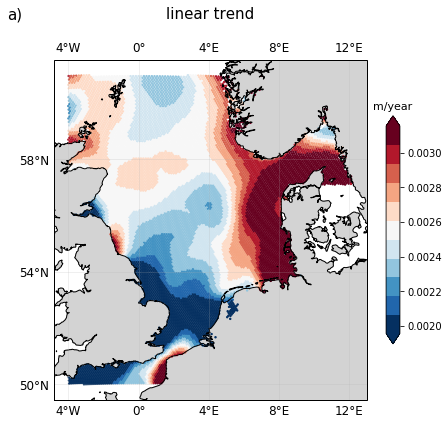

In [64]:
sat_trend.plot(var='trend',msize=2.)

subtract altimetry and TG trends

In [38]:
tg_abs_trend

<xarray.DataArray 'trend' (x: 52)>
array([-2.89730543e-04,  3.09337054e-03,  2.32392800e-03,  2.71534118e-03,
        2.76442087e-03,  2.18899968e-03,  1.26558060e-03,  3.13016719e-03,
        2.23312475e-03,  3.16271113e-03,  9.53539146e-04,  1.58805481e-03,
        2.40542498e-03,  1.82816541e-03,  1.88965877e-03,  2.19368965e-03,
        2.36753075e-03,  9.02949103e-04,  2.25858038e-03,  1.73533711e-03,
        1.16463571e-03,  2.68883181e-03,  1.75700797e-03,  2.11310542e-03,
        1.81480208e-03,  2.56732206e-03,  2.82724024e-03,  3.15434600e-03,
        1.66149108e-04,  2.20929552e-04,  3.85723990e-03,  4.97137801e-06,
        1.17450543e-03,  1.58853169e-03, -4.01031148e-04,  1.09120610e-03,
        1.77770730e-03, -1.21797992e-03,  1.67075410e-03,  1.72351384e-03,
        4.38621161e-03,  2.71818039e-03,  3.18898727e-03,  3.15942405e-03,
        3.90981890e-03,  2.49563163e-03,  1.92395066e-03,  3.00186296e-03,
        4.33562250e-03,  4.93657231e-03,  8.70334053e-04, -2.0200

In [39]:
sat_trend

<xarray.Dataset>
Dimensions:       (x: 12844)
Coordinates:
    lon           (x) float64 7.029 5.129 4.985 ... 0.1696 -0.05653 0.05653
    lat           (x) float64 60.97 60.93 60.94 60.95 ... 50.04 50.04 50.04
Dimensions without coordinates: x
Data variables:
    trend         (x) float64 0.0116 0.003347 0.003211 ... 0.002337 0.002313
    trend_un      (x) float64 0.009216 0.0009939 ... 0.0008369 0.0008651
    trend_un_AR1  (x) float64 0.007486 0.002055 0.001874 ... 0.001522 0.00155
    AC            (x) float64 0.1485 0.09185 0.0843 ... 0.07184 0.07197 0.07193
    AC_unc        (x) float64 0.0906 0.009771 0.008865 ... 0.008226 0.008503
    offset        (x) float64 -0.5146 -0.072 -0.06559 ... -0.05661 -0.05752
    acos          (x) float64 0.1207 0.07506 0.06932 ... 0.04457 0.04469 0.04464
    asin          (x) float64 -0.08649 -0.05293 -0.04796 ... -0.05641 -0.0564
    phase         (x) float64 144.4 144.8 145.3 146.0 ... 128.3 128.4 128.4

swap
nearest
trend
100.0
plot  ['no_var']
shape:  1 x 1


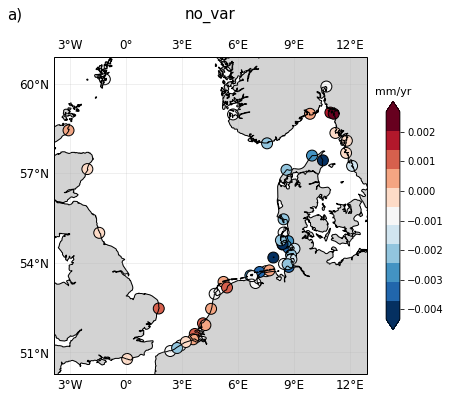

In [37]:
(tg_abs_trend - sat_trend).plot(msize=120.,edgecolors='k')

### 4. correlate data

In [ ]:
tg

swap
(52,)
plot  ['no_var']
shape:  1 x 1


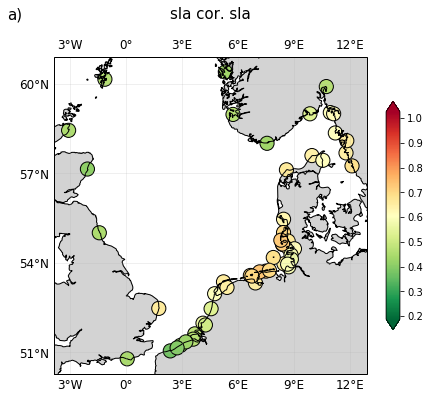

In [81]:
sl(tg['sla']).fltr(how='MAD',mod1=3).detrend(trend_only=True).cor(sat['ssh']).plot(msize=200.,edgecolors=['k'],cmap='RdYlGn_r')

Correlate 1D time series with 3D data

correlate multiple columns
NAO-DJF
(12844,)
EA-DJF
(12844,)
all_
xp
2 2


/home/oelsmann/Julius/Scripts/vlad_globcoast/src/sealeveltools/sealeveltools/sl_plots.py:353: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  clb.set_clim(minv,maxv)


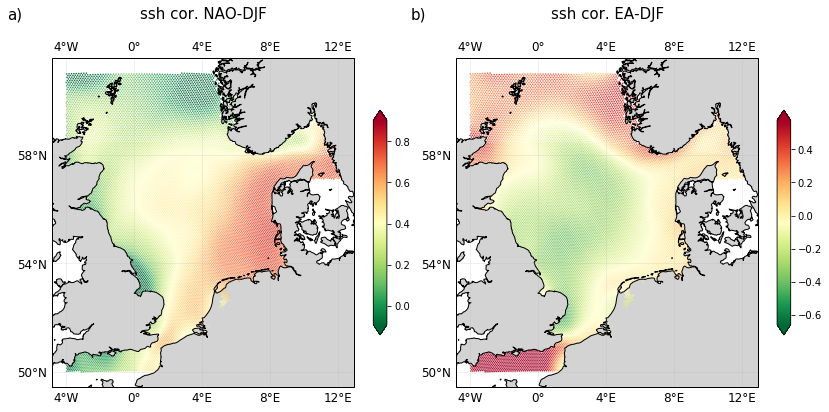

In [146]:
sl(sat).seasmean(seas='DJF').cor(sl(ci[['NAO','EA']]).seasmean(seas='DJF')).plot(var='all_',cmap='RdYlGn_r')

### END